# Import Libraries

In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

Init Plugin
Init Graph Optimizer
Init Kernel


# Read Data

In [2]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [4]:
columns_to_drop = ['label', 'filename', 'length']


def prepare_dataset(df, columns_to_drop, test_size, random_state):
    # Encode the labels from 0 to n_classes-1
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

    # scale the training inputs
    x_train = df_train.drop(columns_to_drop, axis=1)
    y_train = df_train['label'].to_numpy()

    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop, axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy()

    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


## Question 1

Design a feedforward deep neural network (DNN) which consists of an input layer, one hidden layer of 16 neurons with ReLU activation function, and an output softmax layer. Use an stochastic gradient descent with ‘adam’ optimizer with default parameters, and batch size = 1. Apply dropout of probability 0.3 to the hidden layer. Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of input features. We solely assume that there are only two datasets here: training & test. We would look into validation in Question 2 onwards.

In [6]:
class Question1():

    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, num_hidden_neurons=16, batch_size=1):
        self.epochs = epochs
        self.num_hidden_neurons = num_hidden_neurons
        self.batch_size = batch_size
        self.seed = 0
        self.history = None

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def create_model(self):
        # create the model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.num_hidden_neurons, activation='relu'),
            tf.keras.layers.Dropout(rate=0.3, seed=self.seed),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])

        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self, batch_size=None):
        # train the model
        batch_size = batch_size or self.batch_size
        self.history = self.model.fit(x=self.X_train, y=self.y_train,
                                      batch_size=batch_size,
                                      epochs=self.epochs,
                                      verbose=1,
                                      validation_data=(self.X_test, self.y_test))

    def plot_model(self, variable='loss'):
        # plot learning curves
        plt.plot(self.history.history[variable], label='Model training {}'.format(variable))
        plt.plot(self.history.history['val_{}'.format(variable)], label='Model testing {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc="best")
        plt.show()

a) Use the training dataset to train the model for 50 epochs. Note: Use 50 epochs for subsequent experiments.

In [7]:
question1 = Question1(X_train, y_train, X_test, y_test)
question1.create_model()
question1.train_model()

Metal device set to: Apple M1
Epoch 1/50


2021-10-05 03:45:02.670882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-05 03:45:02.670959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-10-05 03:45:02.747248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-05 03:45:02.747422: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-05 03:45:02.852739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


696/700 [============================>.] - ETA: 0s - loss: 2.0825 - accuracy: 0.2313

2021-10-05 03:45:05.184330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


700/700 [==============================] - 3s 4ms/step - loss: 2.0808 - accuracy: 0.2329 - val_loss: 1.7857 - val_accuracy: 0.3667
Epoch 2/50
700/700 [==============================] - 3s 4ms/step - loss: 1.6723 - accuracy: 0.3929 - val_loss: 1.5291 - val_accuracy: 0.4433
Epoch 3/50
700/700 [==============================] - 3s 4ms/step - loss: 1.4676 - accuracy: 0.4429 - val_loss: 1.3954 - val_accuracy: 0.4867
Epoch 4/50
700/700 [==============================] - 3s 4ms/step - loss: 1.3742 - accuracy: 0.4929 - val_loss: 1.2909 - val_accuracy: 0.5167
Epoch 5/50
700/700 [==============================] - 3s 4ms/step - loss: 1.2596 - accuracy: 0.5300 - val_loss: 1.2492 - val_accuracy: 0.5600
Epoch 6/50
700/700 [==============================] - 3s 4ms/step - loss: 1.1984 - accuracy: 0.5743 - val_loss: 1.2200 - val_accuracy: 0.5567
Epoch 7/50
700/700 [==============================] - 3s 4ms/step - loss: 1.1564 - accuracy: 0.5714 - val_loss: 1.1927 - val_accuracy: 0.5733
Epoch 8/50
700/70

b) Plot accuracies on training and test data against training epochs and
comment on the plots.

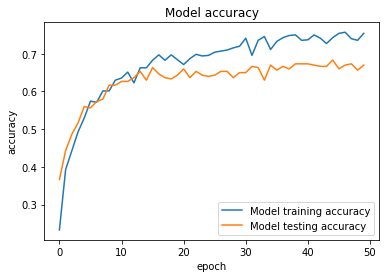

In [8]:
question1.plot_model('accuracy')

c) Plot the losses on training and test data against training epochs. State the approximate number of epochs where the test error begins to converge.

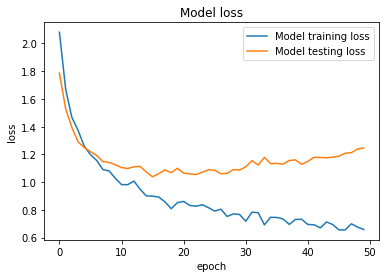

In [9]:
question1.plot_model('loss')

## Question 2

In this question, we will compare the performance of the model using stochastic gradient descent and mini-batch gradient descent, as well as determining the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter selection.

In [10]:
class TimeTakenPerEpochCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_begin_time = time.process_time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.process_time() - self.epoch_begin_time)


class Question2():

    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, num_hidden_neurons=16, batch_size=1,
                 num_experiments=10):
        self.epochs = epochs
        self.num_hidden_neurons = num_hidden_neurons
        self.batch_size = batch_size
        self.num_experiments = num_experiments
        self.batch_sizes = [1, 4, 8, 16, 32, 64]
        self.num_folds = 3
        self.seed = 0
        self.history = None

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def create_model(self):
        # create the model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.num_hidden_neurons, activation='relu'),
            tf.keras.layers.Dropout(rate=0.3, seed=self.seed),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])

        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def cross_validate_run_experiment(self, experiment_X_train, experiment_y_train):
        size_fold = len(experiment_X_train) // self.num_folds
        # batch_size_key -> num_fold_key -> val_accuracy
        experiment_accuracy = {}
        # batch_size_key -> num_fold_key -> time_taken_list
        experiment_time = {}

        for num_fold in range(self.num_folds):
            start, end = num_fold * size_fold, (num_fold + 1) * size_fold
            cv_X_train = np.append(experiment_X_train[:start], experiment_X_train[end:], axis=0)
            cv_y_train = np.append(experiment_y_train[:start], experiment_y_train[end:], axis=0)
            cv_X_test, cv_y_test = experiment_X_train[start:end], experiment_y_train[start:end]

            for batch_size in self.batch_sizes:

                cv_model = tf.keras.Sequential([
                    tf.keras.layers.Dense(units=self.num_hidden_neurons, activation='relu'),
                    tf.keras.layers.Dropout(rate=0.3, seed=self.seed),
                    tf.keras.layers.Dense(units=10, activation='softmax')
                ])

                cv_model.compile(optimizer='adam',
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])

                callback = TimeTakenPerEpochCallback()

                cv_history = cv_model.fit(x=cv_X_train, y=cv_y_train,
                                          batch_size=batch_size,
                                          epochs=self.epochs,
                                          verbose=0,
                                          callbacks=[callback],
                                          validation_data=(cv_X_test, cv_y_test))

                batch_size_key = "batch_size: {}".format(batch_size)
                num_fold_key = "num_fold: {}".format(num_fold)

                # populate experiment_result
                if not experiment_accuracy.get(batch_size_key):
                    experiment_accuracy[batch_size_key] = {}

                experiment_accuracy[batch_size_key][num_fold_key] = cv_history.history['val_accuracy'][self.epochs - 1]

                # populate experiment_time
                if not experiment_time.get(batch_size_key):
                    experiment_time[batch_size_key] = {}

                experiment_time[batch_size_key][num_fold_key] = callback.times

        return (experiment_accuracy, experiment_time)

    def cross_validate_model(self):
        size_X_train = len(self.X_train)
        index = np.arange(size_X_train)
        # experiment -> batch_size_key -> num_fold_key -> val_accuracy
        experiment_accuracies = {}
        # experiment -> batch_size_key -> num_fold_key -> time_taken_per_epoch_list
        experiment_times = {}

        for experiment in range(self.num_experiments):
            np.random.shuffle(index)
            experiment_X_train, experiment_y_train = self.X_train[index], self.y_train[index]
            experiment_accuracy, experiment_time = self.cross_validate_run_experiment(experiment_X_train,
                                                                                      experiment_y_train)
            experiment_key = "experiment: {}".format(experiment)
            experiment_accuracies[experiment_key] = experiment_accuracy
            experiment_times[experiment_key] = experiment_time

        experiment_mean_accuracies = self.cross_validate_get_experiment_mean_accuracies(experiment_accuracies)
        mean_of_experiment_mean_accuracies = self.cross_validate_get_mean_of_experiment_mean_accuracies(
            experiment_mean_accuracies)

        experiment_median_times = self.cross_validate_get_median_of_experiment_times(experiment_times)

        return (mean_of_experiment_mean_accuracies, experiment_median_times)

    @staticmethod
    def cross_validate_get_experiment_mean_accuracies(experiment_accuracies):
        # experiment -> batch_size_key -> mean_val_accuracy
        experiment_mean_accuracies = {}

        for experiment_key in experiment_accuracies.keys():
            experiment_accuracy = experiment_accuracies[experiment_key]
            experiment_mean_accuracy = {}

            for batch_size_key in experiment_accuracy.keys():
                experiment_mean_accuracy[batch_size_key] = np.mean(list(experiment_accuracy[batch_size_key].values()))

            experiment_mean_accuracies[experiment_key] = experiment_mean_accuracy

        return experiment_mean_accuracies

    @staticmethod
    def cross_validate_get_mean_of_experiment_mean_accuracies(experiment_mean_accuracies):
        # batch_size_key -> mean_of_mean_val_accuracy
        mean_of_experiment_mean_accuracies = {}

        for experiment_key in experiment_mean_accuracies.keys():
            experiment_mean_accuracy = experiment_mean_accuracies[experiment_key]

            for batch_size_key in experiment_mean_accuracy:
                if not mean_of_experiment_mean_accuracies.get(batch_size_key):
                    mean_of_experiment_mean_accuracies[batch_size_key] = []
                mean_of_experiment_mean_accuracies[batch_size_key].append(
                    experiment_mean_accuracies[experiment_key][batch_size_key])

        for batch_size_key in mean_of_experiment_mean_accuracies.keys():
            mean_of_experiment_mean_accuracies[batch_size_key] = np.mean(
                mean_of_experiment_mean_accuracies[batch_size_key])

        return mean_of_experiment_mean_accuracies

    @staticmethod
    def cross_validate_get_median_of_experiment_times(experiment_times):
        # batch_size_key -> median_time_taken_per_epoch
        experiment_median_times = {}

        for experiment_key in experiment_times.keys():
            experiment_time = experiment_times[experiment_key]

            for batch_size_key in experiment_time.keys():
                for num_fold_key in experiment_time[batch_size_key]:
                    if not experiment_median_times.get(batch_size_key):
                        experiment_median_times[batch_size_key] = []

                    experiment_median_times[batch_size_key].extend(experiment_time[batch_size_key][num_fold_key])

        for batch_size_key in experiment_median_times.keys():
            experiment_median_times[batch_size_key] = np.median(
                experiment_median_times[batch_size_key])

        return experiment_median_times

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self, batch_size=None):
        # train the model
        batch_size = batch_size or self.batch_size
        self.history = self.model.fit(x=self.X_train, y=self.y_train,
                                      batch_size=batch_size,
                                      epochs=self.epochs,
                                      verbose=1,
                                      validation_data=(self.X_test, self.y_test))

    def plot_model(self, variable='loss'):
        # plot learning curves
        plt.plot(self.history.history[variable], label='Model training {}'.format(variable))
        plt.plot(self.history.history['val_{}'.format(variable)], label='Model testing {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc="best")
        plt.show()

a) Plot mean cross-validation accuracies over the training epochs for different batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.

In [23]:
question2 = Question2(X_train, y_train, X_test, y_test)
mean_of_experiment_mean_accuracies, experiment_median_times = question2.cross_validate_model()
print(mean_of_experiment_mean_accuracies)
optimal_batch_size = max(mean_of_experiment_mean_accuracies, key=mean_of_experiment_mean_accuracies.get)

2021-10-05 03:53:14.765858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:15.959250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:22.532840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:22.945825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:25.169279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:25.419536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-05 03:53:26.686150: I tensorflow/core/grappler/optimizers/cust

{'batch_size: 1': 0.543633778889974, 'batch_size: 4': 0.43347638845443726, 'batch_size: 8': 0.407725324233373, 'batch_size: 16': 0.3075822591781616, 'batch_size: 32': 0.297567958633105, 'batch_size: 64': 0.20600858330726624}


b) Create a table of median time taken to train the network for one epoch against different batch sizes. (Hint: Introduce a callback)

In [24]:
print(experiment_median_times)

{'batch_size: 1': 2.531010000000009, 'batch_size: 4': 0.8454890000000148, 'batch_size: 8': 0.445288000000005, 'batch_size: 16': 0.23240199999997913, 'batch_size: 32': 0.1208780000000047, 'batch_size: 64': 0.07270699999997987}


e) Plot the train and test accuracies against epochs for the optimal batch size. 

Epoch 1/5
 50/700 [=>............................] - ETA: 2s - loss: 2.7582 - accuracy: 0.1200  

2021-10-05 03:53:56.595012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


689/700 [============================>.] - ETA: 0s - loss: 2.1481 - accuracy: 0.2540

2021-10-05 03:53:58.816060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


700/700 [==============================] - 3s 4ms/step - loss: 2.1421 - accuracy: 0.2557 - val_loss: 1.7076 - val_accuracy: 0.4333
Epoch 2/5
700/700 [==============================] - 3s 4ms/step - loss: 1.6906 - accuracy: 0.3871 - val_loss: 1.5037 - val_accuracy: 0.5233
Epoch 3/5
700/700 [==============================] - 3s 4ms/step - loss: 1.4533 - accuracy: 0.4943 - val_loss: 1.3715 - val_accuracy: 0.5500
Epoch 4/5
700/700 [==============================] - 3s 4ms/step - loss: 1.3523 - accuracy: 0.5286 - val_loss: 1.2892 - val_accuracy: 0.5900
Epoch 5/5
700/700 [==============================] - 3s 4ms/step - loss: 1.2462 - accuracy: 0.5429 - val_loss: 1.2246 - val_accuracy: 0.6300


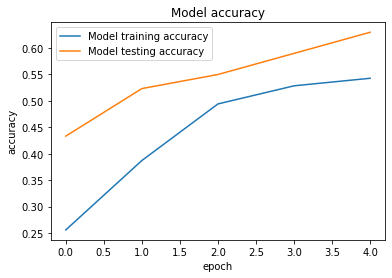

In [25]:
question2.create_model()
question2.train_model(batch_size=int(optimal_batch_size.split(": ")[-1]))
question2.plot_model('accuracy')

## Question 5 (let’s dig deeper!)
We are going to dissect the purpose of dropout in the model.

In [ ]:
class Question5():

    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, num_hidden_neurons=16, batch_size=1):
        self.epochs = epochs
        self.num_hidden_neurons = num_hidden_neurons
        self.batch_size = batch_size
        self.seed = 0
        self.history = None

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def create_model(self):
        # create the model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.num_hidden_neurons, activation='relu'),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])

        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self, batch_size=None):
        # train the model
        batch_size = batch_size or self.batch_size
        self.history = self.model.fit(x=self.X_train, y=self.y_train,
                                      batch_size=batch_size,
                                      epochs=self.epochs,
                                      verbose=1,
                                      validation_data=(self.X_test, self.y_test))

    def plot_model(self, variable='loss'):
        # plot learning curves
        plt.plot(self.history.history[variable], label='Model training {}'.format(variable))
        plt.plot(self.history.history['val_{}'.format(variable)], label='Model testing {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc="best")
        plt.show()

a) Why do we add dropouts? Investigate the purpose of dropouts by removing dropouts from your original 2-layer network (before changing the batch size and number of neurons). Plot accuracies on training and test data with neural network without dropout. Plot as well the losses on training and test data with neural network without dropout.

In [ ]:
question5 = Question5(X_train, y_train, X_test, y_test)
question5.create_model()
question5.train_model()

In [ ]:
question5.plot_model('accuracy')
question5.plot_model('loss')